*Feature importance*
- 변수 중요도
- 이론적인 자세한 부분: https://github.com/Chanjinee/Study/blob/main/HandsOnML/07.%20Ensemble%2C%20Feature%20importance.ipynb
- 이론정리 부분과 함께 공부

## Permutation Importance vs Random Forest Feature Importance (MDI)
- 결국은 이 둘을 모두 사용하여 변수 중요도를 판단하여야함

In [1]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Waeing
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
    
#matplotlib 한글깨짐 지원
import platform
from matplotlib import font_manager, rc
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

- 데이터 불러오기

In [2]:
# 데이터 불러오기
path = './datasets/titanic/'
train = pd.read_csv(path+'train.csv', index_col='PassengerId') # `PassengerId` 열을 인덱스 열로 지정
test = pd.read_csv(path+'test.csv', index_col='PassengerId')

In [3]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


- 간단한 전처리

In [4]:
# encoder 함수 지정
def encoder(data, kind):
    # 범주형 변수와 수치형 변수를 분리
    cat_features = data.select_dtypes(include=['object']).columns.to_list()
    num_features = data.select_dtypes(exclude='object').columns.to_list() 
    if kind == 'onehot':
        # 원핫인코딩
        data_cat = pd.get_dummies(data[cat_features])
        data = pd.concat([data,data_cat],axis=1).drop(columns=[f for f in cat_features])
        return data
    elif kind == 'label':
        # 라벨인코딩
        for c in cat_features:
            data[c]=pd.Categorical(data[c]).codes
        return data
    else:
        print('choose "onehot"or "label"')
# 인코딩
train = encoder(train, 'label')
test = encoder(test, 'label')

In [5]:
# 간단한 결측값 처리
## train
train['Age'] = train['Age'].fillna(train['Age'].mode()[0])
## test
test['Age'] = test['Age'].fillna(test['Age'].mode()[0])
test['Fare'] = test['Fare'].fillna(test['Fare'].mode()[0])

In [6]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train.iloc[:,1:], train.iloc[:,0], test_size=0.2)

- Tree’s Feature Importance from Mean Decrease in Impurity (MDI)

In [7]:
# 그래프에 출력될 feature들의 이름
feature_name = list(train.columns)[1:] # target값 지워줌

def Feature_importance_trees(x_data, y_data, feature_name): # feature_name: 그래프에 출력될 feature들의 이름
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    
    # fitting
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
    decision_tree = DecisionTreeClassifier(random_state=42)
    
    # fitting
    decision_tree.fit(x_data, y_data)
    random_forest.fit(x_data, y_data)
    
    # 변수의 중요도를 시각적으로 확인 비교
    ## decision tree
    feature_importance_dt = decision_tree.feature_importances_
    ## random forest
    feature_importance_rf = random_forest.feature_importances_
    
    #동일하게 처리
    n_feature = x_data.shape[1]
    idx = np.arange(n_feature)

    #dt
    plt.figure(figsize=(20,15))
    plt.subplot(2, 2, 1)
    plt.bar(idx,feature_importance_dt)
    plt.title('DecisionTree Feature Importance', fontsize=20)
    plt.xticks(rotation=90) #x축 값 세로로 변경
    plt.xticks(idx, feature_name, fontsize=15)
    plt.xlabel('feature', size=15)
    plt.ylabel('feature importance', size=15)
    # rf
    plt.subplot(2, 2, 2)
    plt.bar(idx,feature_importance_rf)
    plt.title('RandomFroest Feature Importance', fontsize=20)
    plt.xticks(rotation=90) #x축 값 세로로 변경
    plt.xticks(idx, feature_name, fontsize=15)
    plt.xlabel('feature', size=15)
    plt.ylabel('feature importance', size=15)

    plt.show()

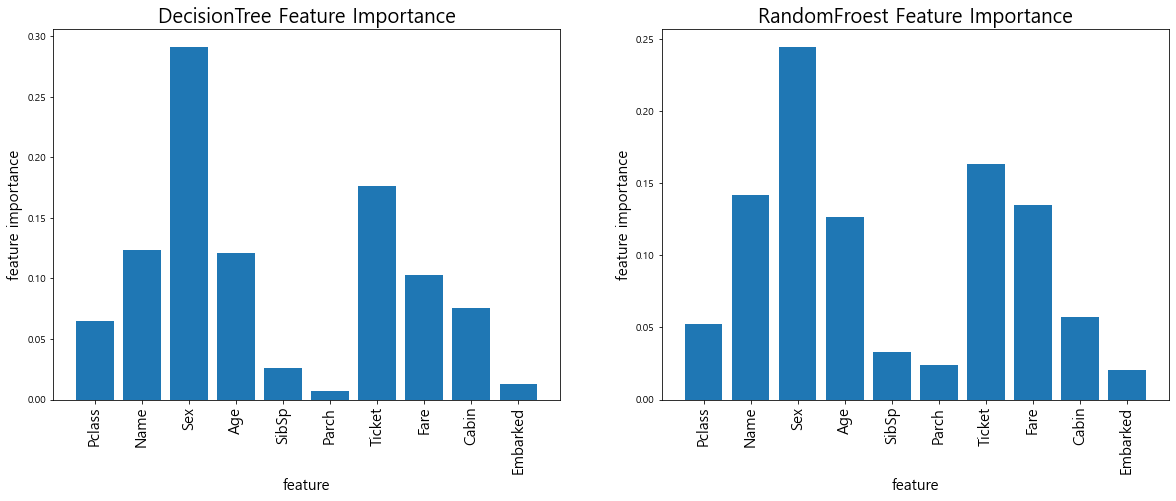

In [8]:
Feature_importance_trees(x_train,y_train, feature_name)

### PermutationImportance 1

In [9]:
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [10]:
# fitting
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)

# fitting
decision_tree.fit(x_train, y_train)
random_forest.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

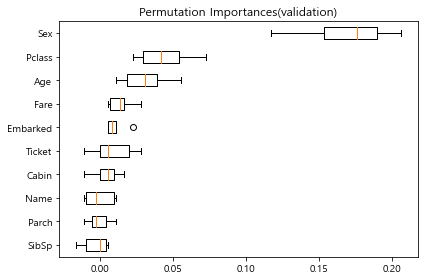

In [11]:
# train에 fit을 하고 vali에서 중요도를 확인
result = permutation_importance(
    random_forest, x_valid, y_valid, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_valid.columns[sorted_idx]
)
ax.set_title("Permutation Importances(validation)")
fig.tight_layout()
plt.show()

### PermutationImportance 2
- scoring을 통해 검증 지표를 설정할 수 있어서 더 효과적임

In [12]:
import eli5 
from eli5.sklearn import PermutationImportance

In [13]:
# permutation importance 
# 검증할 모델설정
model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(x_train, y_train)
# permutation importance 확인
perm = PermutationImportance(model, scoring = "accuracy", random_state = 42).fit(x_valid, y_valid) 
eli5.show_weights(perm,top=40, feature_names = x_valid.columns.tolist())

Weight,Feature
0.1531 ± 0.0461,Sex
0.0436 ± 0.0327,Pclass
0.0425 ± 0.0055,Age
0.0168 ± 0.0158,Ticket
0.0156 ± 0.0109,Fare
0.0123 ± 0.0130,SibSp
0.0112 ± 0.0200,Cabin
0.0056 ± 0.0100,Embarked
0.0034 ± 0.0114,Parch
0.0000 ± 0.0158,Name


## END